In [1]:
from dolfin import *
#from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [284]:
import os

In [285]:
import meshio
import pygmsh
import scipy.sparse
from scipy import spatial

In [286]:
from itertools import combinations_with_replacement, permutations, product
import random

In [872]:
scalar = 2.5

# parameters for box
LENGTH  =  20.0e-2/scalar
WIDTH   =  20.0e-2/scalar
HIGHT   =  5.e-2
START_X = -10.0e-2/scalar
START_Y = -10.0e-2/scalar
START_Z = -2.5e-2

# parameters for cylindars (cells)
num_cell_x   =  1
num_cell_y   =  1
num_cells = num_cell_x*num_cell_y
first_cell_x = 0.02
first_cell_y = 0.02
end_cell_x   = 0.02
end_cell_y   = 0.02
x = np.linspace(first_cell_x, end_cell_x, num_cell_x)
y = np.linspace(first_cell_y, end_cell_y, num_cell_y)
xv, yv = np.meshgrid(x, y)
radius       =  0.01
axis_cell    = [0.0, 0.0, HIGHT]
# constants for temperature field
AREA_CYLINDER = 2 * np.pi * radius * HIGHT
AREA_SIDE = WIDTH * HIGHT
POWER = 90.
T_0 = 20.
q = Constant((POWER/AREA_CYLINDER)) # bdry heat flux

# constants for thermoelastic model
#E = 18e9
#nu = 0.3
#lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
#mu = Constant(E/2/(1+nu))
#alpha = 3.3e-6  # thermal expansion coefficient
#kappa = Constant(alpha*(2*mu + 3*lmbda))
#k = 95  # thermal conductivity
DThole = Constant((POWER/AREA_CYLINDER/235))
#k = Constant(k)

#rho = Constant(1500.)     # density
#cV = Constant(4500000)
T0 = Constant(293.)

f_r = Constant((-1.e6/AREA_SIDE, 0.))
f_t = Constant(( 0., -1.e6/AREA_SIDE))

In [873]:
def Grid_generate():
    matGrid =  [i for i in range(8)]
    matNet = [(i,j) for (i,j) in combinations_with_replacement(matGrid, 2)]
    holeGrid = [i for i in range(2,6)]
    holeNet = [(i,j) for (i,j) in combinations_with_replacement(holeGrid, 2)]
    for i in holeNet:
        matNet.remove(i)
    return matNet, holeNet

In [874]:
def Rand_properties():
    matRan = [random.randint(0,1) for i in range(26)];
    return matRan

In [875]:
ran = Rand_properties()
matNet, holeNet = Grid_generate()

In [876]:
#ran = np.zeros(26, dtype = int)

In [877]:
class KAPPA(UserExpression):
    def eval(self, value, x):
        tol = 1E-14
        for iNet in range(26):
            if matNet[iNet][1]*0.005 + tol <= x[1] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[0] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [2242500, 148500][ran[iNet]]
            if matNet[iNet][0]*0.005 + tol <= x[1] <= matNet[iNet][0]*0.005 + 0.005 + tol and matNet[iNet][1]*0.005 + tol <= x[0] <= matNet[iNet][1]*0.005 + 0.005 + tol:
                value[0] = [2242500, 148500][ran[iNet]]
        for iNet in holeNet:
            if iNet[1]*0.005 + tol <= x[1] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[0] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 2242500
            if iNet[1]*0.005 + tol <= x[0] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[1] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 2242500

# Initialize kappa
kappa = KAPPA(degree=0)

In [878]:
class kei(UserExpression):
    def eval(self, value, x):
        tol = 1E-14
        for iNet in range(26):
            if matNet[iNet][1]*0.005 + tol <= x[1] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[0] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [235, 95][ran[iNet]]
            if matNet[iNet][1]*0.005 + tol <= x[0] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[1] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [235, 95][ran[iNet]]
        for iNet in holeNet:
            if iNet[1]*0.005 + tol <= x[1] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[0] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 235
            if iNet[1]*0.005 + tol <= x[0] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[1] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 235


# Initialize kappa
k = kei(degree=0)

In [879]:
class muu(UserExpression):
    def eval(self, value, x):
        tol = 1E-14
        for iNet in range(26):
            if matNet[iNet][1]*0.005 + tol <= x[1] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[0] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [26538461538.461536, 6923076923.076922][ran[iNet]]
            if matNet[iNet][1]*0.005 + tol <= x[0] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[1] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [26538461538.461536, 6923076923.076922][ran[iNet]]
        for iNet in holeNet:
            if iNet[1]*0.005 + tol <= x[1] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[0] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 26538461538.461536
            if iNet[1]*0.005 + tol <= x[0] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[1] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 26538461538.461536

# Initialize kappa
mu = muu(degree=0)

In [880]:
class lmbdaa(UserExpression):
    def eval(self, value, x):
        tol = 1E-14
        for iNet in range(26):
            if matNet[iNet][1]*0.005 + tol <= x[1] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[0] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [39807692307.69231, 10384615384.615385][ran[iNet]]
            if matNet[iNet][1]*0.005 + tol <= x[0] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[1] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [39807692307.69231, 10384615384.615385][ran[iNet]]
        for iNet in holeNet:
            if iNet[1]*0.005 + tol <= x[1] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[0] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 39807692307.69231
            if iNet[1]*0.005 + tol <= x[0] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[1] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 39807692307.69231

# Initialize kappa
lmbda = lmbdaa(degree=0)

In [881]:
class cvv(UserExpression):
    def eval(self, value, x):
        tol = 1E-14
        for iNet in range(26):
            if matNet[iNet][1]*0.005 + tol <= x[1] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[0] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [2457000, 4500000][ran[iNet]]
            if matNet[iNet][1]*0.005 + tol <= x[0] <= matNet[iNet][1]*0.005 + 0.005 + tol and matNet[iNet][0]*0.005 + tol <= x[1] <= matNet[iNet][0]*0.005 + 0.005 + tol:
                value[0] = [2457000, 4500000][ran[iNet]]
        for iNet in holeNet:
            if iNet[1]*0.005 + tol <= x[1] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[0] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 2457000
            if iNet[1]*0.005 + tol <= x[0] <= iNet[1]*0.005 + 0.005 + tol and iNet[0]*0.005 + tol <= x[1] <= iNet[0]*0.005 + 0.005 + tol:
                value[0] = 2457000

# Initialize kappa
cV = cvv(degree=0)

In [882]:
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_min = 0.002/scalar
    geom.characteristic_length_max = 0.002/scalar
    disk_dic = {}
    disks = []

    rectangle = geom.add_rectangle([START_X, START_Y, 0.], LENGTH, WIDTH)
    for i in range(num_cells):
        name = 'disk' + str(i)
        disk_dic[name] = geom.add_disk([xv.flatten()[i], yv.flatten()[i], 0.], radius)
        disks.append(disk_dic[name])

    rectangle_1 = geom.add_rectangle([START_X, START_Y, 0.], LENGTH, WIDTH/2)
    rectangle_2 = geom.add_rectangle([START_X, 0., 0.], LENGTH/2, WIDTH/2)
    #geom.boolean_difference(rectangle, geom.boolean_union([disks, rectangle_1, rectangle_2]))
    geom.boolean_difference(rectangle, disks)
    geom.boolean_difference(rectangle, rectangle_1)
    geom.boolean_difference(rectangle, rectangle_2)


    mesh = geom.generate_mesh()
    pygmsh.write("test_2d.msh")
    mesh.write("test_2d.vtk")

In [883]:
os.system('gmsh -2 test_2d.msh -format msh2')
os.system('dolfin-convert test_2d.msh mesh_2d.xml')

Info    : Running '/home/haoyuan/anaconda3/envs/fenicsproject/bin/gmsh -2 test_2d.msh -format msh2' [Gmsh 4.10.5, 1 node, max. 1 thread]
Info    : Started on Wed Dec  7 14:42:09 2022
Info    : Reading 'test_2d.msh'...
Info    : 11 entities
Info    : 2535 nodes
Info    : 5075 elements
Info    : Done reading 'test_2d.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 2.3253e-05s, CPU 7e-06s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 3.5092e-05s, CPU 4e-06s)
Info    : 2535 nodes 5075 elements
Info    : Writing 'test_2d.msh'...
Info    : Done writing 'test_2d.msh'
Info    : Stopped on Wed Dec  7 14:42:09 2022 (From start: Wall 0.0148954s, CPU 1.67289s)
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 2535 vertices
Found all vertices
Expecting 4791 cells
Found all cells
Conversion done


0

In [884]:
mesh = Mesh("mesh_2d.xml")

#plt.figure(1)

#plot(mesh)
#plt.show()

In [885]:
Vue = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
Vte = FiniteElement('CG', mesh.ufl_cell(), 1) # temperature finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vte]))

def inner_boundary(x, on_boundary):
    return near((x[0]-0.02)**2+(x[1]-0.02)**2, radius**2, 1e-5) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
def up(x, on_boundary):
    return near(x[1], -START_X) and on_boundary
def right(x, on_boundary):
    return near(x[0], -START_Y) and on_boundary

bc1 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom)
bc2 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc3 = DirichletBC(V.sub(1), DThole, inner_boundary)
bc4 = DirichletBC(V.sub(1), Constant(0.), right)
bc5 = DirichletBC(V.sub(1), Constant(0.), up)
bc7 = DirichletBC(V.sub(0).sub(1), Constant(0.), right)
bc8 = DirichletBC(V.sub(0).sub(0), Constant(0.), up)
bcs = [bc1, bc2, bc3, bc4, bc5,bc7,bc8]

sub_domains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
#AutoSubDomain(lambda x: near(x[1], -START_X)).mark(sub_domains, 14)
#AutoSubDomain(lambda x: near(x[0], -START_Y)).mark(sub_domains, 10)

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] + START_X)< DOLFIN_EPS)

class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[1] + START_Y)< DOLFIN_EPS)
    
    
right_edge = RightBoundary()
top_edge = TopBoundary()
right_edge.mark(sub_domains, 10)
top_edge.mark(sub_domains, 14)

dss = Measure('ds')(subdomain_data=sub_domains)

In [886]:
U_ = TestFunction(V)
(u_, Theta_) = split(U_)
dU = TrialFunction(V)
(du, dTheta) = split(dU)
Uold = Function(V)
(uold, Thetaold) = split(Uold)


def eps(v):
    return sym(grad(v))


def sigma(v, Theta):
    return (lmbda*tr(eps(v)) - kappa*Theta)*Identity(2) + 2*mu*eps(v)


dt = Constant(0.)
mech_form = inner(sigma(du, dTheta), eps(u_))*dx #- (dot(f_r, u_) * dss(10) + dot(f_t, u_) * dss(14) )
#therm_form = (dot(k*grad(dTheta), grad(Theta_)))*dx

therm_form = (cV*(dTheta-Thetaold)/dt*Theta_ + kappa*T0*tr(eps(du-uold))/dt*Theta_ + dot(k*grad(dTheta), grad(Theta_)))*dx
form = mech_form + therm_form


In [887]:
Nincr = 10
t = [i for i in range(1,7)]
Nx = 100
x = np.linspace(0, 0.04, Nx)
T_res = np.zeros((Nx, len(t)))
U = Function(V)
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    T_res[:, i+1] = [U(xi, 0.01)[2] for xi in x]

Increment 1
    Solving linear variational problem.
Increment 2
    Solving linear variational problem.
Increment 3
    Solving linear variational problem.
Increment 4
    Solving linear variational problem.
Increment 5
    Solving linear variational problem.


<IPython.core.display.Javascript object>


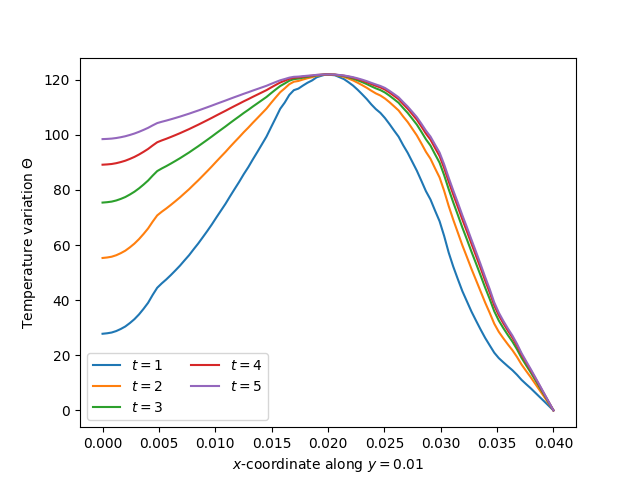

In [888]:
plt.figure()
plt.plot(x, T_res[:,1:])
plt.xlabel("$x$-coordinate along $y=0.01$")
plt.ylabel("Temperature variation $\Theta$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t], ncol=2)
plt.show()

<IPython.core.display.Javascript object>


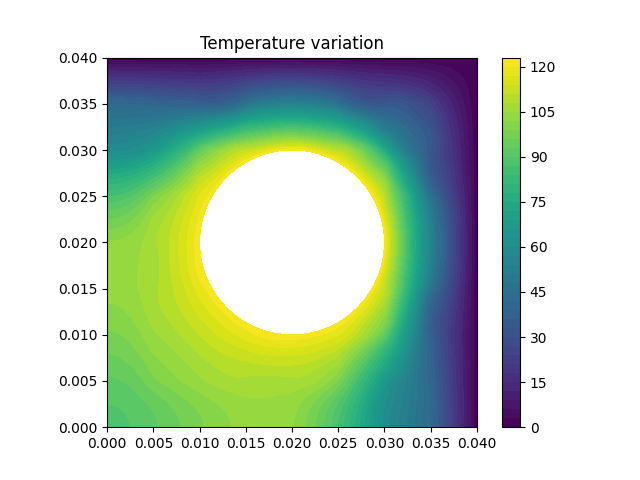

    Object cannot be plotted directly, projecting to piecewise linears.


In [889]:
u, Theta = split(U)
'''
plt.figure()
p = plot(sigma(u, Theta)[0, 0], title="$\sigma_{yy}$ stress near the hole")
plt.colorbar(p)
plt.show()
'''
plt.figure()
p = plot(Theta, title="Temperature variation")
plt.colorbar(p)
plt.show()

In [890]:
for i in range(26):
    print(U(points[i])[2])

91.06445183863067
97.02216668494071
102.47536434163388
104.34682047238425
98.15914405628783
76.15716413444919
51.35155033262366
20.650574561382626
104.40495366936773
110.09285132433311
113.00306673720587
111.58839077458589
93.78682421383023
58.264580752052595
19.208963016334987
71.41398762628967
19.680014312307847
83.97017538457635
25.418389961489055
83.31313667786601
25.101413840530107
65.36030552059292
18.43560173137641
40.89896886987063
14.84538506695323
5.5053495722621


In [891]:
'''
t = np.logspace(1, 4, 5)
U = Function(V)
for (i, dti) in enumerate(np.diff(t)):
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
'''

'\nt = np.logspace(1, 4, 5)\nU = Function(V)\nfor (i, dti) in enumerate(np.diff(t)):\n    dt.assign(dti)\n    solve(lhs(form) == rhs(form), U, bcs)\n    Uold.assign(U)\n'

In [892]:
d = u.geometric_dimension()
s = sigma(u,Theta) - (1./3)*tr(sigma(u,Theta))*Identity(d)
von_Mises = sqrt(3./2*inner(s, s))

<IPython.core.display.Javascript object>


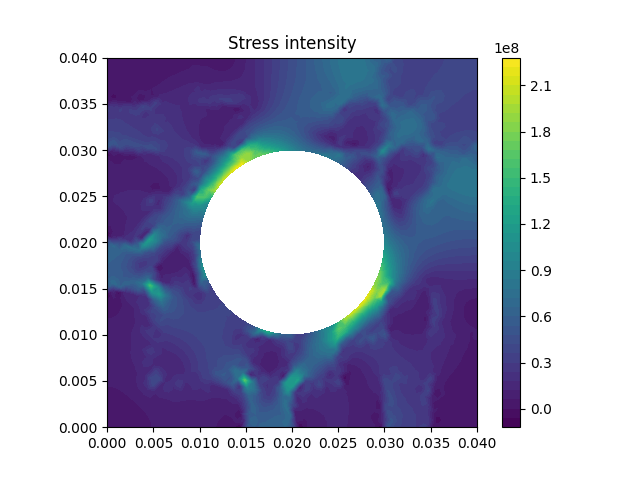

In [893]:
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plt.figure()
p = plot(von_Mises, title='Stress intensity')
plt.colorbar(p)
plt.show()

In [899]:
U(0, 0.01)

array([-1.41399506e-24,  6.36385268e-06,  9.84221798e+01])

In [900]:
np.average(von_Mises.vector())

35463959.72112416

In [901]:
for i in range(26):
    print(von_Mises(points[i]))

4474918.809505158
11633741.26609816
10027266.673342235
43044669.778212756
13454426.913335778
9305319.543976806
30275789.83078522
2438654.0457500736
16047224.585649692
45872296.39816974
8273936.8982970705
61941445.02272026
17896055.450075787
21912676.403540038
8221711.328689256
11062072.775119938
11012454.561776035
57772492.430828355
27705774.312660336
38667727.561883345
58154781.17314507
17478868.976339042
78063391.12562037
75410498.2704261
33548261.15385134
38406601.57616554


In [902]:
for i in range(26):
    print(von_Mises(points[i]))

4474918.809505158
11633741.26609816
10027266.673342235
43044669.778212756
13454426.913335778
9305319.543976806
30275789.83078522
2438654.0457500736
16047224.585649692
45872296.39816974
8273936.8982970705
61941445.02272026
17896055.450075787
21912676.403540038
8221711.328689256
11062072.775119938
11012454.561776035
57772492.430828355
27705774.312660336
38667727.561883345
58154781.17314507
17478868.976339042
78063391.12562037
75410498.2704261
33548261.15385134
38406601.57616554


In [903]:
points = np.array(matNet)*0.005 + 0.0025

In [904]:
points[25]

array([0.0375, 0.0375])

In [905]:
ran[25]

1

In [906]:
for i in range(26):
    print(U(points[i])[2])

91.06445183863067
97.02216668494071
102.47536434163388
104.34682047238425
98.15914405628783
76.15716413444919
51.35155033262366
20.650574561382626
104.40495366936773
110.09285132433311
113.00306673720587
111.58839077458589
93.78682421383023
58.264580752052595
19.208963016334987
71.41398762628967
19.680014312307847
83.97017538457635
25.418389961489055
83.31313667786601
25.101413840530107
65.36030552059292
18.43560173137641
40.89896886987063
14.84538506695323
5.5053495722621


<IPython.core.display.Javascript object>


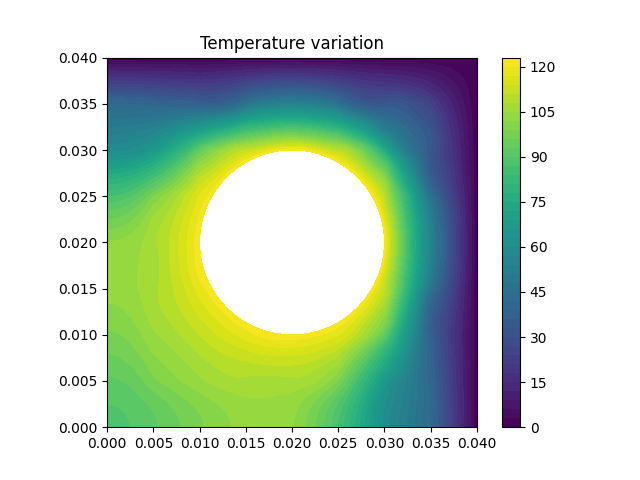

    Object cannot be plotted directly, projecting to piecewise linears.


In [907]:
u, Theta = split(U)
'''
plt.figure()
p = plot(sigma(u, Theta)[0, 0], title="$\sigma_{yy}$ stress near the hole")
plt.colorbar(p)
plt.show()
'''
plt.figure()
p = plot(Theta, title="Temperature variation")
plt.colorbar(p)
plt.show()